# [Introduction] Spatial Contexts for Los Angeles

This notebook sets up a framework for modeling spatial contexts, starting with understanding the data as well as the human contexts.

There are three main ways in which spatial contexts play an important role in health: it contextualizes the built and social environment, environmental exposure, and access to health services for communities. 

## CalEPA Data

The following data was compiled from the California Environmental Protection Agency (CalEPA) Cal Enviro Screen (CES) indicator and demographic data, focusing on LA County, California.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0)

In [70]:
df

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,CES 4.0 Percentile,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100%,0.048,...,99.97,13.34,72.59,14.07,97.27,1.71,0.84,0.00,0.00,0.18
1,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,95-100%,0.043,...,99.94,11.34,77.53,11.13,65.34,0.54,33.55,0.00,0.57,0.00
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100%,0.042,...,99.91,18.60,72.48,8.92,78.14,1.09,15.67,0.00,4.84,0.25
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100%,0.049,...,99.87,7.70,84.50,7.80,75.55,2.85,10.45,0.00,6.95,4.20
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100%,0.041,...,99.86,12.77,73.16,14.07,69.34,3.98,8.43,0.00,16.32,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,6037980026,26,Los Angeles,91042,Los Angeles,-118.263309,34.273483,NaN,NaN,0.066,...,NaN,0.00,100.00,0.00,26.92,26.92,42.31,0.00,0.00,3.85
2093,6037980028,0,Los Angeles,90045,Los Angeles,-118.417488,33.942108,NaN,NaN,0.043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2094,6037980030,0,Los Angeles,90245,El Segundo,-118.409478,33.909624,NaN,NaN,0.043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2095,6037980031,1175,Los Angeles,90731,Los Angeles,-118.262727,33.733835,NaN,NaN,0.038,...,NaN,1.70,88.60,9.70,32.94,33.45,19.74,2.21,5.10,6.55


In [4]:
df.shape

(2097, 67)

Note: by subsetting into just LA County from the original CAlEPA dataset, the CES 4.0 percentiles adjustments need to be accounted for. The percentiles are relative to California, not LA County.

Here's all of the available features:

In [5]:
print(list(df.columns))

['Census Tract', 'Total Population', 'California County', 'ZIP', 'Approximate Location', 'Longitude', 'Latitude', 'CES 4.0 Score', 'CES 4.0 Percentile Range', 'Ozone', 'Ozone Pctl', 'PM2.5', 'PM2.5 Pctl', 'Diesel PM', 'Diesel PM Pctl', 'Drinking Water', 'Drinking Water Pctl', 'Lead', 'Lead Pctl', 'Pesticides', 'Pesticides Pctl', 'Tox. Release', 'Tox. Release Pctl', 'Traffic', 'Traffic Pctl', 'Cleanup Sites', 'Cleanup Sites Pctl', 'Groundwater Threats', 'Groundwater Threats Pctl', 'Haz. Waste', 'Haz. Waste Pctl', 'Imp. Water Bodies', 'Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl', 'Pollution Burden', 'Pollution Burden Score', 'Pollution Burden Pctl', 'Asthma', 'Asthma Pctl', 'Low Birth Weight', 'Low Birth Weight Pctl', 'Cardiovascular Disease', 'Cardiovascular Disease Pctl', 'Education', 'Education Pctl', 'Linguistic Isolation', 'Linguistic Isolation Pctl', 'Poverty', 'Poverty Pctl', 'Unemployment', 'Unemployment Pctl', 'Housing Burden', 'Housing Burden Pctl', 'Pop. Char. '

Now let's look at the unique approximate locations:

In [6]:
print(list(df['Approximate Location'].unique()))

['Los Angeles', 'Compton', 'South El Monte', 'El Monte', 'South Gate', 'Long Beach', 'Commerce', 'Bell Gardens', 'Bell', 'Cudahy', 'Huntington Park', 'Glendale', 'Gardena', 'Lynwood', 'Baldwin Park', 'Pomona', 'Inglewood', 'Paramount', 'Maywood', 'Montebello', 'Industry', 'Azusa', 'Hawthorne', 'Carson', 'Santa Fe Springs', 'Pico Rivera', 'La Puente', 'Norwalk', 'Burbank', 'Hawaiian Gardens', 'Bellflower', 'Rosemead', 'San Fernando', 'Downey', 'Whittier', 'Monterey Park', 'Lancaster', 'Lawndale', 'San Gabriel', 'Santa Monica', 'Irwindale', 'Alhambra', 'West Covina', 'Covina', 'Culver City', 'Lakewood', 'Palmdale', 'Signal Hill', 'Duarte', 'Monrovia', 'La Mirada', 'Pasadena', 'Artesia', 'Santa Clarita', 'La Verne', 'Temple City', 'West Hollywood', 'Cerritos', 'Claremont', 'Torrance', 'Glendora', 'Lomita', 'San Dimas', 'El Segundo', 'Beverly Hills', 'Diamond Bar', 'Walnut', 'Calabasas', 'Arcadia', 'Redondo Beach', 'South Pasadena', 'Agoura Hills', 'Avalon', 'Rancho Palos Verdes', 'Hidden 

### Distribution of CES 4.0 Scores

*Describe CES 4.0 Score from CalEPA definition + brief introduction*

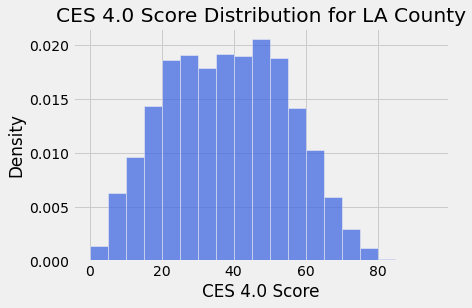

In [69]:
# Distribution of CES 4.0 Scores

sns.histplot(data=df, x='CES 4.0 Score', stat='density', bins=np.arange(0, 100, 5), color='royalblue')
plt.title("CES 4.0 Score Distribution for LA County")

In [8]:
# Summary of CES 4.0 Scores

df.describe()[['CES 4.0 Score']]

,CES 4.0 Score
count,2060.000000
mean,38.178044
std,16.714094
min,2.160000
25%,24.852500
50%,38.325000
75%,51.007500
max,82.390000


Text(0.5, 1.0, 'CES 4.0 Percentile Distribution for LA County (relative to California)')

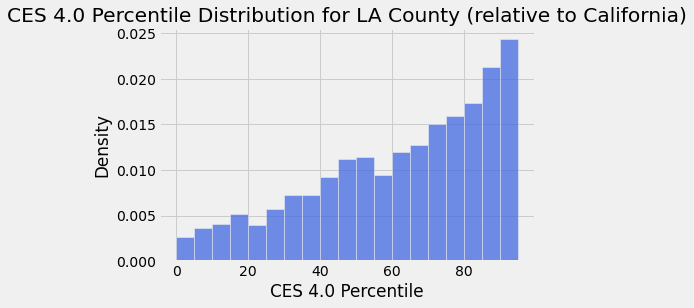

In [9]:
# Distribution of CES 4.0 Score Percentiles (relative to California)

sns.histplot(data=df, x='CES 4.0 Percentile', stat='density', color='royalblue', bins=np.arange(0, 100, 5))
plt.title("CES 4.0 Percentile Distribution for LA County (relative to California)")

Text(0.5, 1.0, 'CES 4.0 Percentile Distribution for LA County (relative to California)')

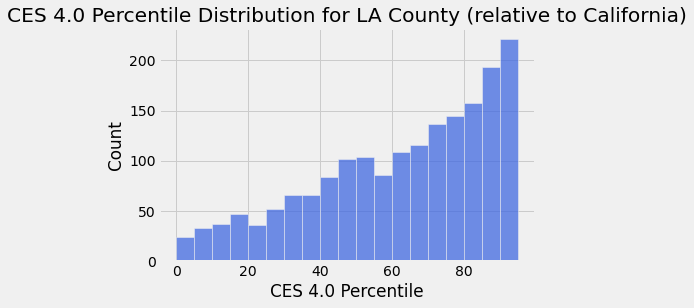

In [67]:
# Count of CES 4.0 Score Percentiles (relative to California)

sns.histplot(data=df, x='CES 4.0 Percentile', stat='count', color='royalblue', bins=np.arange(0, 100, 5))
plt.title("CES 4.0 Percentile Distribution for LA County (relative to California)")

In [10]:
# Summary of CES 4.0 Percentiles

df.describe()[['CES 4.0 Percentile']]

,CES 4.0 Percentile
count,2060.000000
mean,66.705146
std,25.800615
min,0.290000
25%,48.407500
50%,72.660000
75%,88.872500
max,99.970000


Just within LA County, the distributions show us that LA County has some of the lowest CES 4.0 Scores as well as some of the highest.

In [11]:
# CES 4.0 Score averages by city

ces_avg_by_city = df[['Approximate Location', 'CES 4.0 Score']].groupby(by='Approximate Location').mean().dropna().sort_values(by='CES 4.0 Score', ascending=False)
ces_avg_by_city

,CES 4.0 Score
Approximate Location,
Commerce,68.520000
South El Monte,67.106000
Bell Gardens,63.267778
Compton,62.094783
Cudahy,60.566667
...,...
Manhattan Beach,7.008750
Palos Verdes Estates,6.856667
Rolling Hills Estates,6.630000


### Relationship of CES 4.0 Scores to Population Characteristics

<b>Race/Ethnicity</b>

*CES 4.0 with consideration to Race and Ethnicity* --> Wikipedia page

In [12]:
df_pop = df[['Census Tract', 'Longitude', 'Latitude','CES 4.0 Score', 'Hispanic (%)', 'White (%)', 'African American (%)', 'Native American (%)', 'Asian American (%)', 'Other/Multiple (%)']]
df_pop

,Census Tract,Longitude,Latitude,CES 4.0 Score,Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6037204920,-118.197497,34.017500,82.39,97.27,1.71,0.84,0.00,0.00,0.18
1,6037542402,-118.212413,33.881969,80.71,65.34,0.54,33.55,0.00,0.57,0.00
2,6037543202,-118.230032,33.879862,79.29,78.14,1.09,15.67,0.00,4.84,0.25
3,6037203300,-118.207788,34.058872,77.35,75.55,2.85,10.45,0.00,6.95,4.20
4,6037291220,-118.286709,33.877139,77.25,69.34,3.98,8.43,0.00,16.32,1.92
...,...,...,...,...,...,...,...,...,...,...
2092,6037980026,-118.263309,34.273483,NaN,26.92,26.92,42.31,0.00,0.00,3.85
2093,6037980028,-118.417488,33.942108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2094,6037980030,-118.409478,33.909624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2095,6037980031,-118.262727,33.733835,NaN,32.94,33.45,19.74,2.21,5.10,6.55


Let's take a look at the correlation between CES 4.0 Score and each of the race/ethnicity categories provided by the CalEPA. With visualizations, we can continue to make more sense of it. For now, we will drop null values.

In [13]:
correlations = df_pop.iloc[:, 3:].corr()['CES 4.0 Score']
correlations

CES 4.0 Score           1.000000
Hispanic (%)            0.728616
White (%)              -0.712795
African American (%)    0.197267
Native American (%)    -0.026868
Asian American (%)     -0.249784
Other/Multiple (%)     -0.486382
Name: CES 4.0 Score, dtype: float64

In [14]:
df_pop_corr = df_pop.iloc[:, 3:].dropna()

<AxesSubplot:xlabel='Hispanic (%)', ylabel='CES 4.0 Score'>

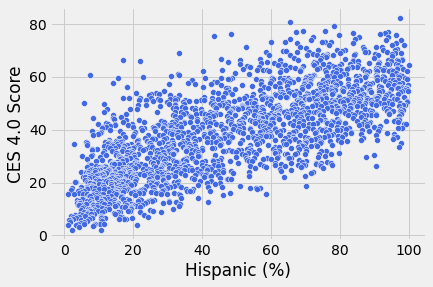

In [15]:
sns.scatterplot(data=df_pop_corr, x='Hispanic (%)', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='White (%)', ylabel='CES 4.0 Score'>

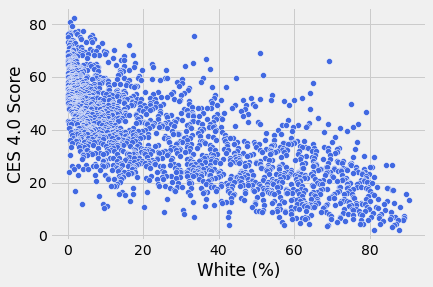

In [16]:
sns.scatterplot(data=df_pop_corr, x='White (%)', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='African American (%)', ylabel='CES 4.0 Score'>

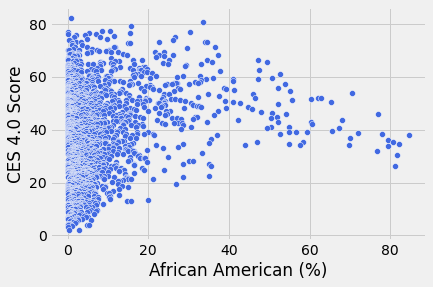

In [17]:
sns.scatterplot(data=df_pop_corr, x='African American (%)', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Native American (%)', ylabel='CES 4.0 Score'>

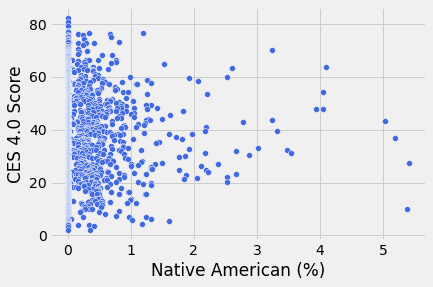

In [18]:
sns.scatterplot(data=df_pop_corr, x='Native American (%)', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Asian American (%)', ylabel='CES 4.0 Score'>

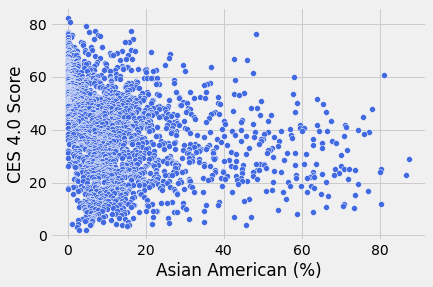

In [19]:
sns.scatterplot(data=df_pop_corr, x='Asian American (%)', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Other/Multiple (%)', ylabel='CES 4.0 Score'>

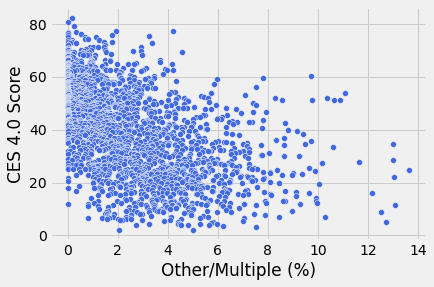

In [20]:
sns.scatterplot(data=df_pop_corr, x='Other/Multiple (%)', y='CES 4.0 Score', color='royalblue')

<b>Population Indicators</b>

*Importance of population indicators with CES 4.0 Scores, as well as census tracts without scores + population indicators*

In [21]:
df_pi = df[['Census Tract', 'Longitude', 'Latitude', 'CES 4.0 Score', 'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden']]
df_pi

,Census Tract,Longitude,Latitude,CES 4.0 Score,Education,Linguistic Isolation,Poverty,Unemployment,Housing Burden
0,6037204920,-118.197497,34.017500,82.39,52.2,17.1,62.6,6.4,20.3
1,6037542402,-118.212413,33.881969,80.71,33.1,NaN,43.5,9.3,23.7
2,6037543202,-118.230032,33.879862,79.29,43.3,9.7,56.8,12.6,29.6
3,6037203300,-118.207788,34.058872,77.35,52.1,28.4,71.7,11.9,28.3
4,6037291220,-118.286709,33.877139,77.25,31.6,20.1,51.5,4.5,26.1
...,...,...,...,...,...,...,...,...,...
2092,6037980026,-118.263309,34.273483,NaN,NaN,NaN,NaN,NaN,NaN
2093,6037980028,-118.417488,33.942108,NaN,NaN,NaN,NaN,NaN,NaN
2094,6037980030,-118.409478,33.909624,NaN,NaN,NaN,NaN,NaN,NaN
2095,6037980031,-118.262727,33.733835,NaN,8.0,NaN,NaN,NaN,NaN


In [22]:
correlations_pi = df_pi.iloc[:, 3:].corr()['CES 4.0 Score']
correlations_pi

CES 4.0 Score           1.000000
Education               0.786717
Linguistic Isolation    0.525501
Poverty                 0.770195
Unemployment            0.400755
Housing Burden          0.618670
Name: CES 4.0 Score, dtype: float64

In [23]:
df_pi_corr = df_pi.iloc[:, 3:].dropna()

<AxesSubplot:xlabel='Education', ylabel='CES 4.0 Score'>

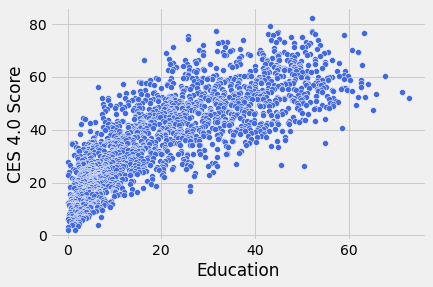

In [24]:
sns.scatterplot(data=df_pi_corr, x='Education', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Linguistic Isolation', ylabel='CES 4.0 Score'>

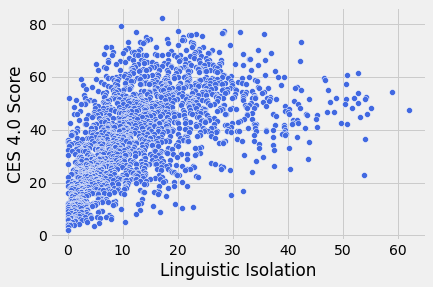

In [25]:
sns.scatterplot(data=df_pi_corr, x='Linguistic Isolation', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Poverty', ylabel='CES 4.0 Score'>

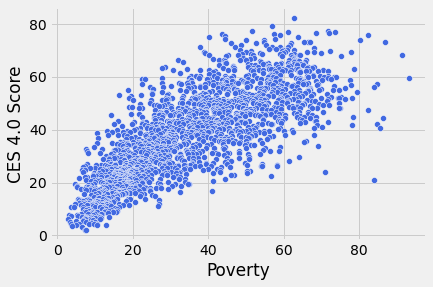

In [26]:
sns.scatterplot(data=df_pi_corr, x='Poverty', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Housing Burden', ylabel='CES 4.0 Score'>

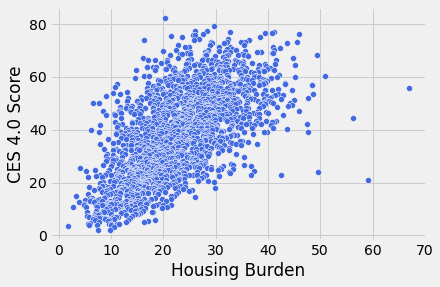

In [27]:
sns.scatterplot(data=df_pi_corr, x='Housing Burden', y='CES 4.0 Score', color='royalblue')

<AxesSubplot:xlabel='Unemployment', ylabel='CES 4.0 Score'>

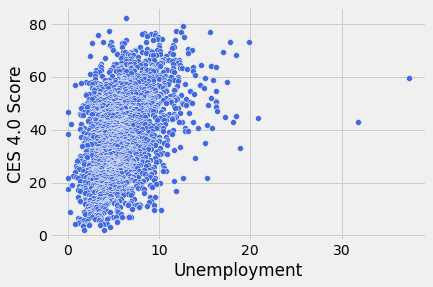

In [71]:
sns.scatterplot(data=df_pi_corr, x='Unemployment', y='CES 4.0 Score', color='royalblue')

### Relationship of CES 4.0 Scores to Pollution Burden